In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Удаляем ненужные столбцы
cols_to_drop = ['ApplicationDate', 'HomeOwnershipStatus', 'MaritalStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# Удаляем строки с NaN
train_df = train_df.dropna()
test_df = test_df.dropna()

# Удаляем дубликаты
train_df.drop_duplicates(inplace=True)

label_encoder = LabelEncoder()
train_df['LoanApproved'] = label_encoder.fit_transform(train_df['LoanApproved'])

test_df = test_df.drop(columns=['LoanApproved'])

X = train_df.drop(columns=['LoanApproved', 'RiskScore'])
y = train_df['LoanApproved']

X_test = test_df.drop(columns=['ID'])

scaler = StandardScaler()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [3]:
class MyLinearLogisticClassifier:
    def __init__(self, lr=0.01, num_iter=1000, method='logistic'):
        self.lr = lr
        self.num_iter = num_iter
        self.method = method

    def fit(self, X, y):
        self.theta = np.zeros(X.shape[1])
        for _ in range(self.num_iter):
            linear_model = np.dot(X, self.theta)
            
            if self.method == 'logistic':
                y_pred = 1 / (1 + np.exp(-linear_model))  
            else:
                y_pred = np.where(linear_model >= 0, 1, 0)  
            
            gradient = np.dot(X.T, (y_pred - y)) / y.size
            self.theta -= self.lr * gradient

    def predict(self, X):
        linear_model = np.dot(X, self.theta)
        
        if self.method == 'logistic':
            y_pred = 1 / (1 + np.exp(-linear_model))
            return (y_pred >= 0.5).astype(int)
        else:
            return np.where(linear_model >= 0, 1, 0) 

custom_lr = MyLinearLogisticClassifier(method='logistic')
custom_lr.fit(X_train, y_train)
y_pred_custom_lr = custom_lr.predict(X_valid)

custom_linear = MyLinearLogisticClassifier(method='linear')
custom_linear.fit(X_train, y_train)
y_pred_custom_linear = custom_linear.predict(X_valid)

In [4]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    results[model_name] = {
        'accuracy': accuracy_score(y_valid, y_pred),
        'precision': precision_score(y_valid, y_pred),
        'recall': recall_score(y_valid, y_pred),
        'f1': f1_score(y_valid, y_pred),
        'confusion_matrix': confusion_matrix(y_valid, y_pred)
    }

[LightGBM] [Info] Number of positive: 3402, number of negative: 3268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4562
[LightGBM] [Info] Number of data points in the train set: 6670, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510045 -> initscore=0.040185
[LightGBM] [Info] Start training from score 0.040185


Logistic Regression:
Accuracy: 0.9360
Precision: 0.9348
Recall: 0.9429
F1 Score: 0.9388


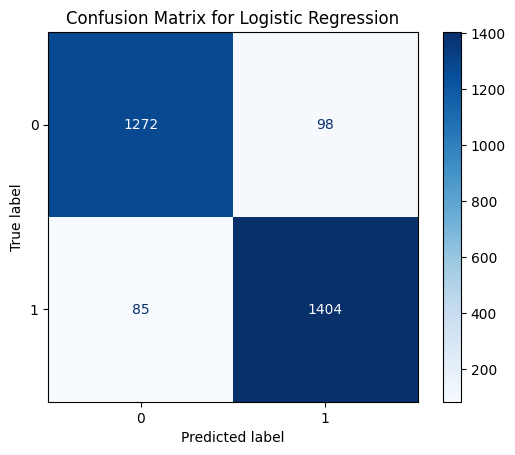

SVM:
Accuracy: 0.9325
Precision: 0.9432
Recall: 0.9261
F1 Score: 0.9346


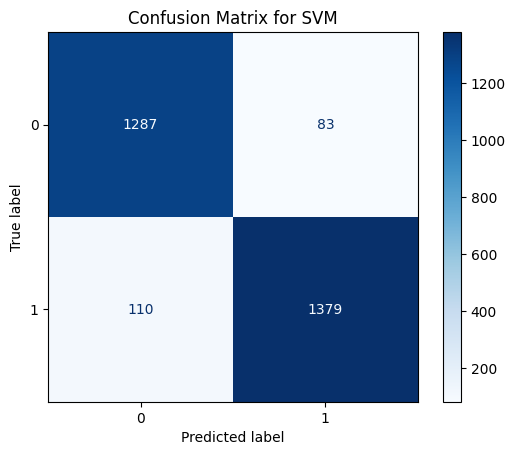

Decision Tree:
Accuracy: 0.8821
Precision: 0.8908
Recall: 0.8818
F1 Score: 0.8863


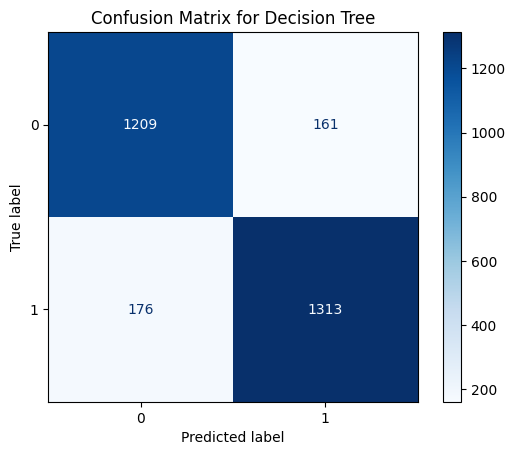

Random Forest:
Accuracy: 0.9234
Precision: 0.9216
Recall: 0.9322
F1 Score: 0.9269


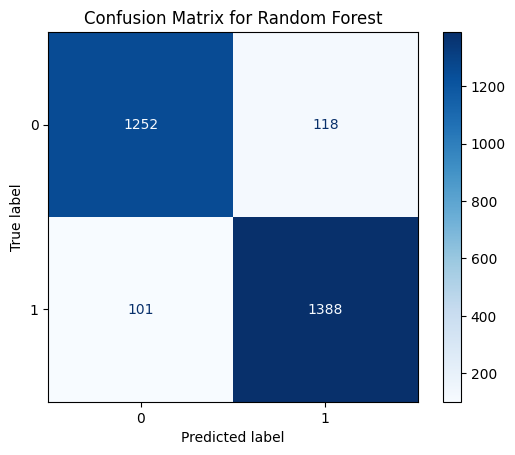

Gradient Boosting:
Accuracy: 0.9262
Precision: 0.9232
Recall: 0.9362
F1 Score: 0.9296


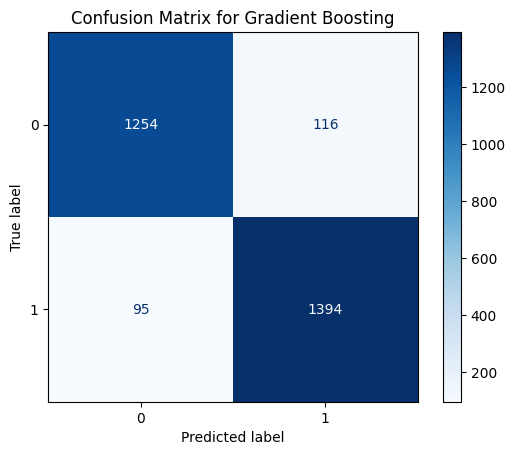

XGBoost:
Accuracy: 0.9269
Precision: 0.9313
Recall: 0.9281
F1 Score: 0.9297


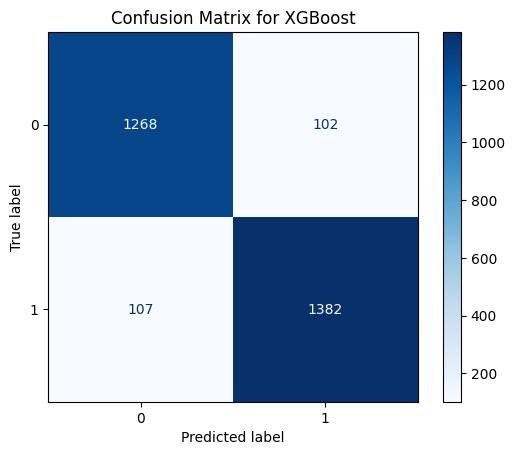

LightGBM:
Accuracy: 0.9272
Precision: 0.9228
Recall: 0.9389
F1 Score: 0.9308


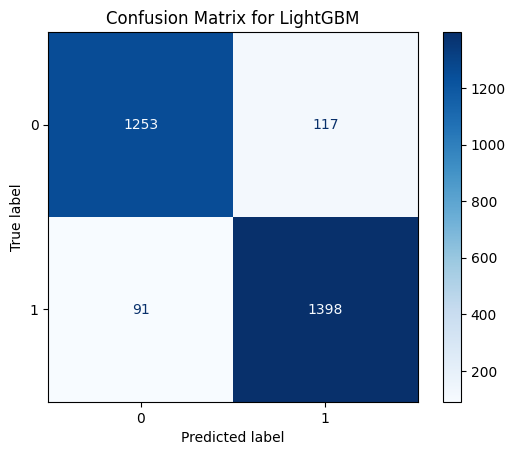

CatBoost:
Accuracy: 0.9307
Precision: 0.9312
Recall: 0.9362
F1 Score: 0.9337


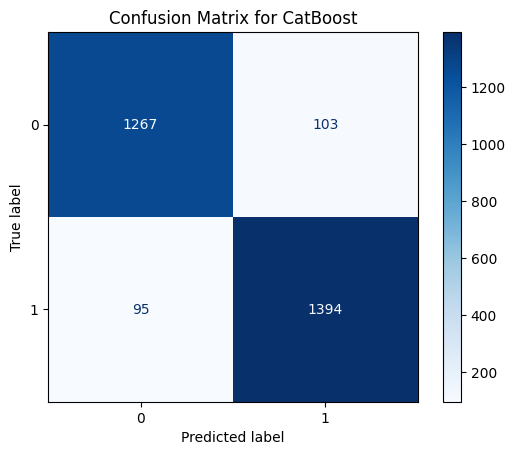

My Logistic Regression:
Accuracy: 0.9122
Precision: 0.9222
Recall: 0.9080
F1 Score: 0.9151


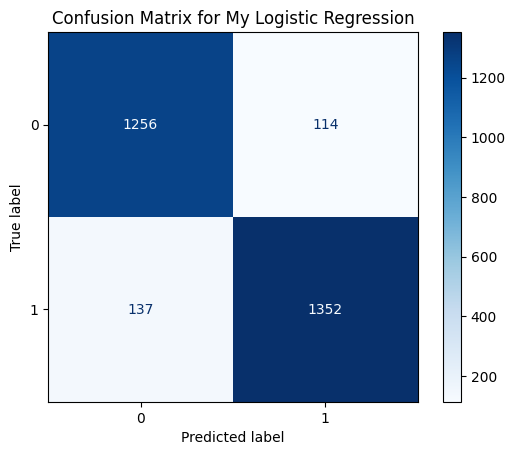


My Linear Classifier:
Accuracy: 0.9171
Precision: 0.9311
Recall: 0.9080
F1 Score: 0.9194


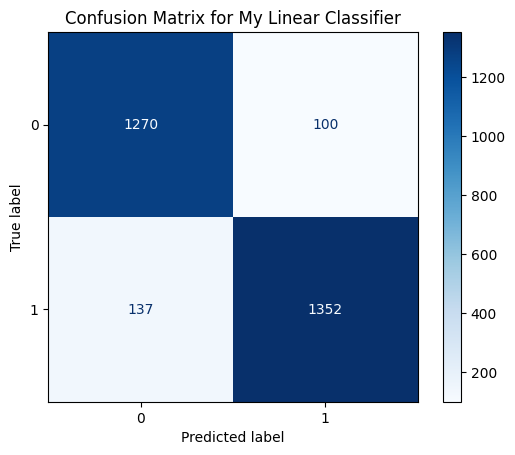

In [5]:
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

print("My Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_valid, y_pred_custom_lr):.4f}")
print(f"Precision: {precision_score(y_valid, y_pred_custom_lr):.4f}")
print(f"Recall: {recall_score(y_valid, y_pred_custom_lr):.4f}")
print(f"F1 Score: {f1_score(y_valid, y_pred_custom_lr):.4f}")

cm_custom_lr = confusion_matrix(y_valid, y_pred_custom_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom_lr)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for My Logistic Regression")
plt.show()

print("\nMy Linear Classifier:")
print(f"Accuracy: {accuracy_score(y_valid, y_pred_custom_linear):.4f}")
print(f"Precision: {precision_score(y_valid, y_pred_custom_linear):.4f}")
print(f"Recall: {recall_score(y_valid, y_pred_custom_linear):.4f}")
print(f"F1 Score: {f1_score(y_valid, y_pred_custom_linear):.4f}")

cm_custom_linear = confusion_matrix(y_valid, y_pred_custom_linear)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom_linear)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for My Linear Classifier")
plt.show()


Вывод: 

Среди всех протестированных моделей наилучшие результаты по метрикам точности Accuracy и F1 Score показали логистическая регрессия и CatBoost. Эти модели продемонстрировали стабильное качество предсказаний и хороший баланс между точностью и полнотой. Такие методы как Random Forest, Gradient Boosting, XGBoost и LightGBM, также продемонстрировали высокие результаты, с точностью около 92.5% - 92.7%. Хотя SVM показал высокие результаты, его F1 Score немного уступает логистической регрессии. Decision Tree продемонстрировал наихудшие результаты среди моделей, что говорит о склонности этой модели к переобучению на данных. Большинство моделей показали высокие значения Recall и Precision, что говорит о хорошем умении предсказывать оба класса и минимизации ошибок. Например, у логистической регрессии Recall составляет 0.9429, что указывает на способность модели правильно выявлять положительные примеры. Моя логистическая регрессия продемонстрировала точность 0.9122 и F1 Score 0.9151, что говорит о хорошем балансе между предсказанием положительных и отрицательных классов, а линейный классификатор показал еще более высокую точность 0.9171 и F1 Score 0.9194, что делает его конкурентоспособным среди других моделей, особенно учитывая его простоту. В нашей задаче классификации наиболее информативной метрикой является F1 Score, так как она учитывает как Precision, так и Recall, что особенно важно при работе с несбалансированными данными или когда необходимо минимизировать как ложные положительные, так и ложные отрицательные предсказания. Высокий F1 Score позволяет оценить общий баланс между точностью и полнотой модели.